In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

In [3]:
df = pd.read_csv('dataCarSale2021-2025.csv')

df['waktu'] = pd.to_datetime(df['waktu'])
df = df.set_index('waktu')

df.info()
print(df.describe())
print(df.head(60))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2021-01-01 to 2025-07-01
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    54 non-null     float64
 1   HONDA       54 non-null     float64
 2   MITSUBISHI  54 non-null     float64
 3   SUZUKI      54 non-null     float64
 4   TOYOTA      54 non-null     float64
dtypes: float64(5)
memory usage: 2.5 KB
           DAIHATSU         HONDA    MITSUBISHI        SUZUKI        TOYOTA
count     54.000000     54.000000     54.000000     54.000000     54.000000
mean   11254.531630   7645.139556   8760.141000   5609.579630  19934.127907
std     4597.871605   3886.261244   3351.676613   2351.526395   7855.556087
min     5755.232000   1590.411000   4349.666000   2004.813000   7617.122000
25%     7477.087250   3855.075250   6204.000000   3227.915000  12472.187250
50%     9310.389000   7725.500000   7637.046000   5830.500000  20983.500000
75%    15638.000000

In [6]:
df_extra = pd.read_csv('extra_feature_engineering_withGeminii.csv')

df_extra.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 56 entries, ('    2021-01-01;3', '75;1', '55;84') to ('    2025-08-01;5;2', '4;118', '1;0;1')
Data columns (total 1 columns):
 #   Column                                                                                                 Non-Null Count  Dtype 
---  ------                                                                                                 --------------  ----- 
 0   waktu;bi_policy_rate_pct;inflation_yoy_pct;consumer_confidence_index;is_lebaran_season;is_giias_month  41 non-null     object
dtypes: object(1)
memory usage: 6.9+ KB


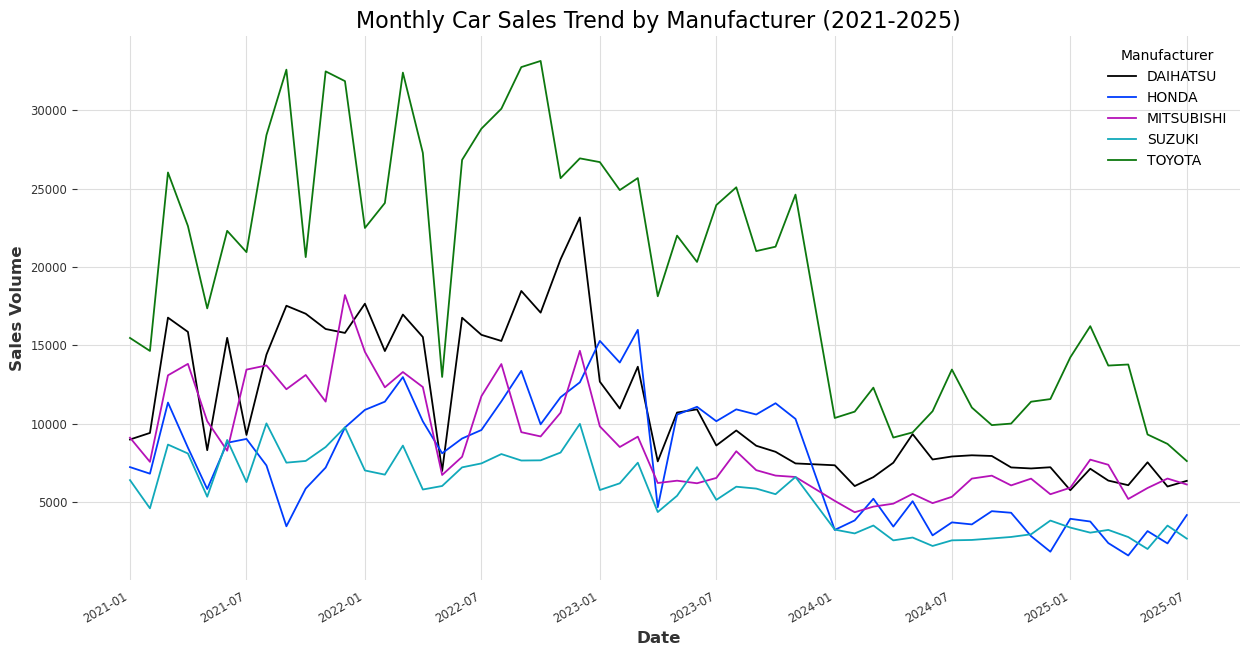

In [25]:
df.plot(figsize=(15, 8), linestyle='-')
plt.title('Monthly Car Sales Trend by Manufacturer (2021-2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.legend(title='Manufacturer')
plt.grid(True)
plt.show()

In [26]:
# # Calculate total sales to use as the target variable
# df['TOTAL_SALES'] = df.sum(axis=1)

# def create_features(df):
#     """Function to create time-series features from a datetime index."""
#     df['year'] = df.index.year
#     df['month'] = df.index.month
#     df['quarter'] = df.index.quarter
#     df['dayofyear'] = df.index.dayofyear
#     df['weekofyear'] = df.index.isocalendar().week.astype(int)

#     return df

# df = create_features(df)

# # Define features and the target
# FEATURES = ['year', 'month', 'quarter', 'dayofyear', 'weekofyear']
# TARGETS = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']

# for brand in TARGETS:
#     df[f'{brand}_lag1'] = df[brand].shift(1)
#     df[f'{brand}_lag3'] = df[brand].shift(3)
#     # df[f'{brand}_lag12'] = df[brand].shift(12)
    
#     # 移動平均特徴量 (過去3ヶ月と12ヶ月の平均)
#     df[f'{brand}_rolling_mean3'] = df[brand].shift(1).rolling(window=3).mean()
#     # df[f'{brand}_rolling_mean12'] = df[brand].shift(1).rolling(window=12).mean()
    
#     # 移動標準偏差 (過去3ヶ月)
#     df[f'{brand}_rolling_std3'] = df[brand].shift(1).rolling(window=3).std()
# df = df.dropna()

# X = df[FEATURES]
# y = df[TARGETS]



# print(df.head(20))


In [ ]:
# --- 必要なライブラリとモデルのインポート ---
import pandas as pd
from darts import TimeSeries
from darts.metrics import smape

# 試したいモデルをDartsからインポート
from darts.models import (
    ARIMA,AutoARIMA,
    ExponentialSmoothing,
    Theta,
    FFT # Fast Fourier Transform
)

# --- 1. データの準備 (以前と同様) ---
target_brand = 'SUZUKI'
series = TimeSeries.from_series(df[target_brand], freq='MS')
train, val = series.split_before(pd.Timestamp('20250101'))


# --- 2. 試したいモデルのリストを作成 ---
# モデルの名前と、インスタンス化したモデルを辞書として定義
models_to_try = {
    # "ARIMA": ARIMA(),
    "AutoARIMA": AutoARIMA(seasonal=True,             # 12ヶ月の季節性を考慮
        stepwise=True,
        suppress_warnings=True),
    "ExponentialSmoothing": ExponentialSmoothing(),
    "Theta": Theta(),
    "FFT": FFT()
}


# --- 3. ループですべてのモデルを学習・評価 ---
print("Evaluating various models...")
results = []

for model_name, model in models_to_try.items():
    try:
        # モデルの学習
        model.fit(train)
        
        # 予測の実行
        prediction = model.predict(len(val))
        
        # SMAPEの計算
        smape_score = smape(val, prediction)
        
        # 結果を保存
        results.append({
            "Model": model_name,
            "SMAPE (%)": smape_score
        })
        
        print(f"  - {model_name} SMAPE: {smape_score:.2f}%")
        
    except Exception as e:
        # モデルがエラーになった場合
        print(f"  - {model_name} failed with error: {e}")
        results.append({
            "Model": model_name,
            "SMAPE (%)": None
        })


# --- 4. 結果を比較する ---
df_results = pd.DataFrame(results)
print("\n--- Model Comparison Results ---")
print(df_results.sort_values(by="SMAPE (%)").reset_index(drop=True))

TypeError: AutoARIMA.__init__() got an unexpected keyword argument 'm'